# Non-Cartesian sampling: SPARKLING imaging

We explore the performance of SPARKLING (_Spreading projection Algorithm for
Rapid K-space sampLING_) as non-Cartesian imaging technique. We do not
actually provide the code of this algorithm but instead upload result files
containing trajectories generated from the previous *radial in-out*
initialization.
For details, see the recently published paper:
Lazarus et al, "SPARKLING: variable‐density k‐space filling curves for accelerated $T_2^*$‐weighted MRI", Magn Reson Med 2019; 81:3643:3661.

- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 06/24/2022
- Update: 01/29/2024 (dependence on MRI-NUFFT for density compensation)
- Update: 01/30/2024: add 2D cones
- Target: [IEEE EMBS-SPS Summer School](http://conferences.imt-atlantique.fr/ieeess/index.php?pid=1) on **Novel acquisition and image reconstruction strategies in accelerated Magnetic Resonance Imaging**

(256, 256)


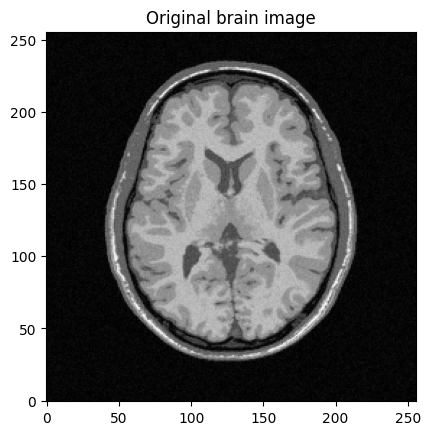

In [17]:
#DISPLAY T2* MR IMAGE
%matplotlib inline

import numpy as np
import os.path as op
import os
import math
import cmath
import matplotlib.pyplot as plt
import sys

import brainweb_dl as bwdl

import mrinufft as mn
from mrinufft import get_density, displayConfig
from mrinufft.trajectories import display
from mrinufft.density import voronoi
from mrinufft.trajectories import initialize_2D_spiral
from mrinufft.trajectories.display import display_2D_trajectory


plt.rcParams["image.origin"]="lower"
plt.rcParams["image.cmap"]='Greys_r'

mri_img = bwdl.get_mri(4, "T1")[80,:,:].astype(np.float32)
print(mri_img.shape)
img_size = mri_img.shape[0]
plt.figure()
plt.imshow(abs(mri_img))
plt.title("Original brain image")
plt.show()

In [12]:
from scipy.io import loadmat

cwd = os.getcwd()
dirimg_2d = op.join(cwd,"..","data")

k_spark = loadmat(op.join(cwd, "..", "data","samples_SPARKLING_N512_nc34x3073_OS1.mat"))
rfactor = img_size/34
print(np.floor(rfactor))
k_spark_vec = k_spark['samples']

Kmax = np.amax(k_spark_vec)
#print(Kmax)

k_spark_vec = k_spark_vec*1/(2*np.pi*Kmax)

#save in npz format in the outdir directory
outdir = op.join(cwd,"..","output")
filename_traj = "sparkling_radial_N"  + str(img_size) + ".npz"
outfile = op.join(outdir, filename_traj)
np.savez(outfile, k_spark_vec)

k_spark = plt.figure(figsize=(7,7))
plt.scatter(k_spark_vec[:,0],k_spark_vec[:,1], marker = '.', s=0.1)
plt.grid()
#Figure layout

unit = 1/4
tick = np.arange(-0.5, 0.5 + unit, unit)

label = [r"$-\frac{1}{2}$", r"$-\frac{1}{4}$", r"$0$", r"$+\frac{1}{4}$",  r"$+\frac{1}{2}$"]

plt.xticks(tick/np.pi,labels = label, fontsize = 16) ; plt.yticks(tick/np.pi,labels = label, fontsize = 16)
plt.xlabel(r"$k_x$", fontsize = 22) ; plt.ylabel(r"$k_y$", fontsize = 22)
plt.title("K-space sampling, spiral in-out initialization",fontsize = 18)
plt.show()

7.0


FileNotFoundError: [Errno 2] No such file or directory: '/volatile/home/pc174679/codes/mri-acq-recon-book/src/../output/sparkling_radial_N256.npz'

In [18]:
# Display parameters
figure_size = 5.5  # Figure size for trajectory plots
subfigure_size = 3  # Figure size for subplots
one_shot = 0  # Highlight one shot in particular

def show_density(density, figure_size, *, log_scale=False):
    density = density.T[::-1]

    plt.figure(figsize=(figure_size, figure_size))
    if log_scale:
        plt.imshow(density, cmap="jet", norm=colors.LogNorm())
    else:
        plt.imshow(density, cmap="jet")

    ax = plt.gca()
    ax.set_xlabel("kx", fontsize=displayConfig.fontsize)
    ax.set_ylabel("ky", fontsize=displayConfig.fontsize)
    ax.set_aspect("equal")

    plt.axis(False)
    plt.colorbar()
    plt.show()


def show_densities(function, arguments, subfig_size, *, log_scale=False):
    # Initialize k-space densities with varying option
    densities = [function(arg).T[::-1] for arg in arguments]

    # Plot the trajectories side by side
    fig, axes = plt.subplots(
        1,
        len(densities),
        figsize=(len(densities) * subfig_size, subfig_size),
        constrained_layout=True,
    )

    for ax, arg, density in zip(axes, arguments, densities):
        ax.set_title(str(arg), fontsize=displayConfig.fontsize)
        ax.set_xlabel("kx", fontsize=displayConfig.fontsize)
        ax.set_ylabel("ky", fontsize=displayConfig.fontsize)
        ax.set_aspect("equal")
        if log_scale:
            ax.imshow(density, cmap="jet", norm=colors.LogNorm())
        else:
            ax.imshow(density, cmap="jet")
        ax.axis(False)
    plt.show()


def show_locations(function, arguments, subfig_size, *, log_scale=False):
    # Initialize k-space locations with varying option
    locations = [function(arg) for arg in arguments]

    # Plot the trajectories side by side
    fig, axes = plt.subplots(
        1,
        len(locations),
        figsize=(len(locations) * subfig_size, subfig_size),
        constrained_layout=True,
    )

    for ax, arg, location in zip(axes, arguments, locations):
        ax.set_title(str(arg), fontsize=displayConfig.fontsize)
        ax.set_xlim(-1.05 * KMAX, 1.05 * KMAX)
        ax.set_ylim(-1.05 * KMAX, 1.05 * KMAX)
        ax.set_xlabel("kx", fontsize=displayConfig.fontsize)
        ax.set_ylabel("ky", fontsize=displayConfig.fontsize)
        ax.set_aspect("equal")
        ax.scatter(location[..., 0], location[..., 1], s=3)
    plt.show()

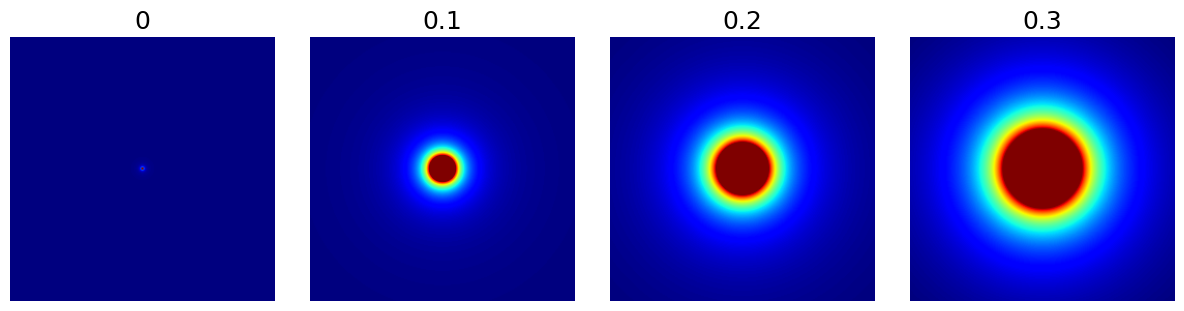

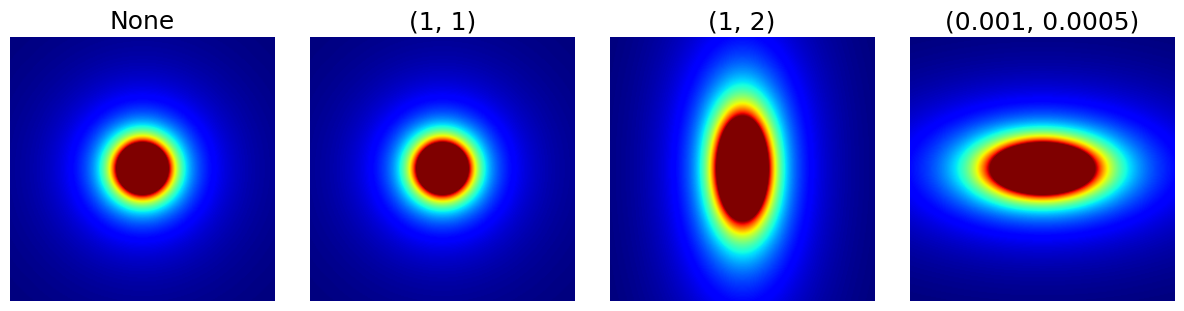

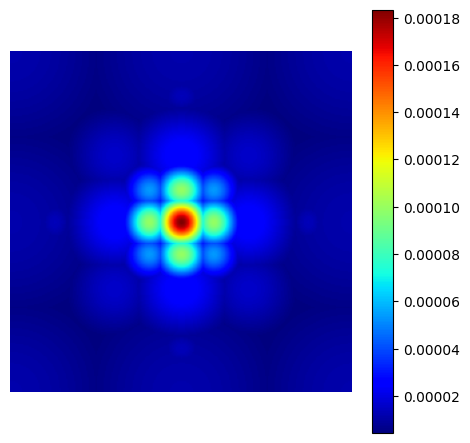

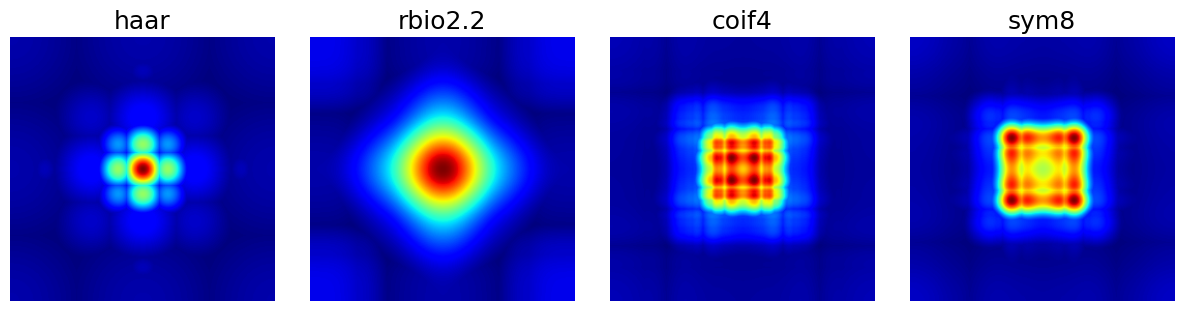

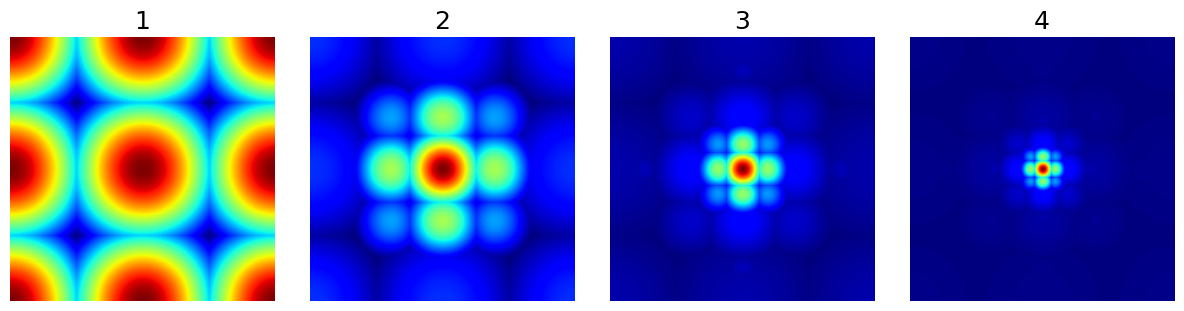

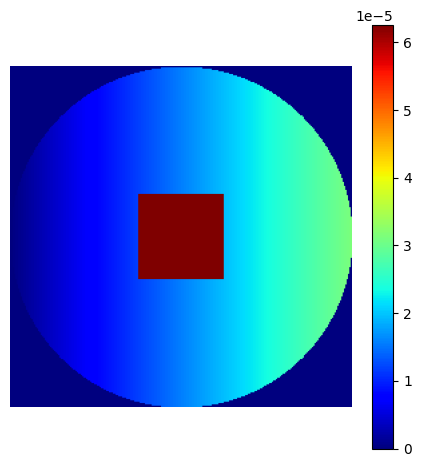

In [25]:
#Cutoff/decay density
cutoff_density = mn.create_cutoff_decay_density(shape=shape_2d, cutoff=0.2, decay=2)
show_density(cutoff_density, figure_size=figure_size)

#cutoff (float)
arguments = [0, 0.1, 0.2, 0.3]
function = lambda x: mn.create_cutoff_decay_density(
    shape=shape_2d,
    cutoff=x,
    decay=2,
    resolution=x,
)

show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

#decay (float)
arguments = [-1, 0, 0.5, 2]
# Density parameters
shape_2d = (img_size, img_size)

function = lambda x: mn.create_cutoff_decay_density(
    shape=shape_2d,
    cutoff=0.2,
    decay=x,
)
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

arguments = [None, (1, 1), (1, 2), (1e-3, 0.5e-3)]

#dataset = bwdl.get_mri(4, "T1")[:, ::2, ::2]
#energy_density = mn.create_energy_density(dataset=dataset)
#show_density(energy_density, figure_size=figure_size, log_scale=True)


chauffert_density = mn.create_chauffert_density(
    shape=shape_2d,
    wavelet_basis="haar",
    nb_wavelet_scales=3,
)
show_density(chauffert_density, figure_size=figure_size)

arguments = ["haar", "rbio2.2", "coif4", "sym8"]
function = lambda x: mn.create_chauffert_density(
    shape=shape_2d,
    wavelet_basis=x,
    nb_wavelet_scales=3,
)
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

arguments = [1, 2, 3, 4]
function = lambda x: mn.create_chauffert_density(
    shape=shape_2d,
    wavelet_basis="haar",
    nb_wavelet_scales=x,
)
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

# Linear gradient
density = np.tile(np.linspace(0, 1, shape_2d[1])[:, None], (1, shape_2d[0]))
# Square center
density[
    3 * shape_2d[0] // 8 : 5 * shape_2d[0] // 8,
    3 * shape_2d[1] // 8 : 5 * shape_2d[1] // 8,
] = 2
# Outer circle
density = np.where(
    np.linalg.norm(np.indices(shape_2d) - shape_2d[0] / 2, axis=0) < shape_2d[0] / 2,
    density,
    0,
)
# Normalization
custom_density = density / np.sum(density)

show_density(custom_density, figure_size=figure_size)

In [24]:
densities = {
    "Cutoff/Decay": cutoff_density,
    "Energy": energy_density,
    "Chauffert": chauffert_density,
    "Custom": custom_density,
}

arguments = densities.keys()
function = lambda x: densities[x]
show_densities(function, arguments, subfig_size=subfigure_size)

NameError: name 'chauffert_density' is not defined

In [8]:
rfactor = 4
nb_shots = math.ceil(img_size/rfactor)
print("number of shots: {}".format(nb_shots))

# define the regularly spaced samples on a single shot
num_samples = img_size

# Density parameters
shape_2d = (img_size, img_size)
cutoff_density = mn.create_cutoff_decay_density(shape=shape_2d, cutoff=0.2, decay=2)
#show_density(cutoff_density, figure_size=figure_size)

function = lambda x: mn.sample_from_density(nb_shots * num_samples, densities[x], method="lloyd")

arguments = densities.keys()
show_locations(function, arguments, subfig_size=subfigure_size)

number of shots: 64


NameError: name 'densities' is not defined

In [ ]:
data=convert_locations_to_mask(k_spark_vec, mri_img.shape)
#fourier_op = NonCartesianFFT(samples=k_spark_vec, shape=mri_img.shape,
#                             implementation='cpu')
#kspace_obs = fourier_op.op(mri_img.data)

NufftOperator = mrinufft.get_operator("finufft")
# For better image quality we use a density compensation
#density = "voronoi"
density = "cell_count"
#density = None
# And create the associated operator.
if density == None:
    nufft = NufftOperator(
        k_spark_vec.reshape(-1, 2), shape=mri_img.shape, density=None, n_coils=1
    )
elif density == "voronoi":
    voronoi_weights = get_density("voronoi", k_spark_vec.reshape(-1, 2))
    nufft = NufftOperator(
        k_spark_vec.reshape(-1, 2), shape=mri_img.shape, density=voronoi_weights, n_coils=1
    )
else:
    cell_count_weights = get_density("cell_count", k_spark_vec.reshape(-1, 2), shape=mri_img.shape, osf=2.0)
    nufft = NufftOperator(
        k_spark_vec.reshape(-1, 2), shape=mri_img.shape, density=cell_count_weights, n_coils=1, upsampfac=2.0
    )

kspace_obs = nufft.op(mri_img.data)  # Image -> Kspace
image2 = nufft.adj_op(kspace_obs)  # Kspace -> Image

In [ ]:
grid_space = np.linspace(-0.5, 0.5, num=mri_img.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
#grid_soln = gridded_inverse_fourier_trans#form_nd(k_spark_vec, kspace_obs,
#                                                 tuple(grid2D), 'linear')
#plt.imshow(np.abs(grid_soln), cmap='gray'
plt.imshow(np.abs(image2), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image2, mri_img)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(k_spark_vec.reshape(-1, 2))
fig = voronoi_plot_2d(vor)

fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
                      line_width=2, line_alpha=0.6, point_size=2)
plt.show()

In [ ]:
import brainweb_dl as bwdl
from mrinufft.trajectories import initialize_2D_cones
from mrinufft.trajectories.display import display_2D_trajectory

mri_2D = bwdl.get_mri(4, "T1")[80, ...].astype(np.float32)
print(mri_2D.shape)
plt.figure()
plt.imshow(abs(mri_2D))
plt.show()

In [ ]:
from mrinufft import get_density, get_operator, check_backend

traj = initialize_2D_cones(256, 256).astype(np.float32)

nufft = get_operator("finufft")(traj, mri_2D.shape, density=False)
kspace = nufft.op(mri_2D)
adjoint = nufft.adj_op(kspace)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(abs(mri_2D))
display_2D_trajectory(traj, subfigure=axs[1])
axs[2].imshow(abs(adjoint))

voronoi_weights = get_density("voronoi", traj)
nufft_voronoi = get_operator("finufft")(
    traj, shape=mri_2D.shape, density=voronoi_weights
)
adjoint_voronoi = nufft_voronoi.adj_op(kspace)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(abs(mri_2D))
display_2D_trajectory(traj, subfigure=axs[1])
axs[2].imshow(abs(adjoint_voronoi))

flat_traj = traj.reshape(-1, 2)
weights = np.sqrt(np.sum(flat_traj**2, axis=1))
nufft = get_operator("finufft")(traj, shape=mri_2D.shape, density=weights)
adjoint_manual = nufft.adj_op(kspace)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(abs(mri_2D))
axs[0].set_title("Ground Truth")
axs[1].imshow(abs(adjoint))
axs[1].set_title("no density compensation")
axs[2].imshow(abs(adjoint_manual))
axs[2].set_title("manual density compensation")